In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

In [2]:
import torch
import torch.nn as nn
import pandas as pd
from data_process import *
from data_split import *
from torch.utils.data import Dataset, DataLoader

In [3]:
def mygenerate_data(root_path, by_txt=True, shuffle=True, factor=0.2, snr=5, resample=True):
    """
    根据打好标签的 txt 文件导入数据，并按文件来划分训练集以及测试集
    其中训练集，测试集默认按 0.8 0.2 比例划分
    数据集目录结构: area/data/, area/txt/
    """
    data_root, txt_root = root_path + '/data', root_path + '/txt'
    train_data, test_data = [], []
    file_data_dict = {}

    file_name_list = os.listdir(data_root)

    for file_name in file_name_list:
        
        file_path = data_root + '/' + file_name
        
        dataXYZ = pd.read_csv(file_path, header= 0)

        data_x, data_y, data_z = list(dataXYZ.iloc[:,0]), list(dataXYZ.iloc[:, 1]), list(dataXYZ.iloc[:, 2])
        
        if resample:
            data_x, data_y, data_z = data_resample(data_x, 2, 1), data_resample(data_y, 2, 1), \
                data_resample(data_z, 2, 1)
        
        dataXYZ = pd.DataFrame()
        dataXYZ['x'] = data_x
        dataXYZ['y'] = data_y
        dataXYZ['z'] = data_z

        base_value = cal_base_value(dataXYZ, 16, 8, 200)
        
        if by_txt:
            txt_path = txt_root + '/' + file_name[:-3] + 'txt'
            with open(txt_path, 'r') as f:
                activity_list = f.readlines()
            activity_list = [int(activity[:-1]) for activity in activity_list]
        else:
            activity_list = [int(np.mean(idx)) for idx in activitySplit(dataXYZ, 16, 8, 200)]

        new_list = []
        for center in activity_list:
            item = {'data_x': np.array(extract_data_from_center(data_x, center, base_value[0], length=48)),
                    'data_y': np.array(extract_data_from_center(data_y, center, base_value[1], length=48)),
                    'data_z': np.array(extract_data_from_center(data_z, center, base_value[2], length=48)),
                    'label': get_activity_label(file_name), 'file_name': file_name, 'base_value':base_value,
                    'angle': cal_angles(base_value), 'area': get_area_label(root_path) }
            
            noise_z = np.array(extract_data_from_center(data_z, center+32, base_value[2], 48))
            item['snr'] = cal_snr(item['data_z']-item['base_value'][2], noise_z-item['base_value'][2])

            
            new_list.append(item)
        # activity_list = [{'data_x': np.array(extract_data_from_center(data_x, center, base_value[0])),
        #                 'data_y': np.array(extract_data_from_center(data_y, center, base_value[1])),
        #                 'data_z': np.array(extract_data_from_center(data_z, center, base_value[2])),
        #                 'label': get_activity_label(file_name), 'file_name': file_name, 'base_value':base_value,
        #                 'angle': cal_angles(base_value), 'area': get_area_label(root_path) }
        #                 for center in activity_list]
        
        file_data_dict[file_name] = filter_by_snr(new_list, snr)

        if shuffle:
            random.shuffle(new_list)
        
        test_data = test_data + new_list[: int(factor * len(new_list))]
        train_data = train_data + new_list[int(factor * len(new_list)): ]
        
    return filter_by_snr(train_data, snr), filter_by_snr(test_data, snr), file_name_list, file_data_dict

In [4]:
def sig_diff(sig):
    return [sig[1]-sig[0]] + [sig[i+1] - sig[i] for i in range(len(sig)-1)]

def newhandle_data_3dims(item, mode='origin'):
    """
    将单个切割出来的数据处理按mode处理成三轴数
    mode: 'origin'-只减基线，'combine'-转换为x2+y2+z2, x2+y2, z三轴数据
    """
    base, angle = item['base_value'], item['angle'] # xyz的基线，以及其与g的夹角
    data_x, data_y, data_z = item['data_x'], item['data_y'], item['data_z']
    var = [0.00076385, 0.00017194, 0.00071417, 0.000022871, 0.000040234]

    if mode == 'combine':
        data_xyz = np.sqrt((data_x-base[0])**2 + (data_y-base[1])**2 + (data_z-base[2])**2) # x2+y2+z2不论如何都减基线
        data_z_rectify = (data_x-base[0]) * angle['x'] + (data_y-base[1]) * angle['y'] + (data_z-base[2]) * angle['z']
        data_xy = np.sqrt((data_x-base[0])**2 + (data_y-base[1])**2)
        
        data = np.array([cut_mean(data_xyz) / np.sqrt(var[0]), cut_mean(data_xy) / np.sqrt(var[1]), \
            cut_mean(data_z_rectify) / np.sqrt(var[2])], dtype=np.float64)

    elif mode == 'origin':
        data = np.array([data_x-base[0], data_y-base[1], data_z-base[2]], dtype=np.float64)

    elif mode == 'all':
        data_xyz = np.sqrt((data_x-base[0])**2 + (data_y-base[1])**2 + (data_z-base[2])**2) # x2+y2+z2不论如何都减基线
        data_z_rectify = (data_x-base[0]) * angle['x'] + (data_y-base[1]) * angle['y'] + (data_z-base[2]) * angle['z']
        data_xy = np.sqrt((data_x-base[0])**2 + (data_y-base[1])**2)

        data = np.array([cut_mean(data_xyz) / np.sqrt(var[0]), \
            cut_mean(data_xy) / np.sqrt(var[1]), \
            cut_mean(data_z_rectify) / np.sqrt(var[2]), \
            cut_mean(data_x) / np.sqrt(var[3]), \
            cut_mean(data_y) / np.sqrt(var[4])], dtype=np.float64)

    elif mode == 'diff':
        diff_x, diff_y, diff_z = sig_diff(data_x), sig_diff(data_y), sig_diff(data_z)
        data = np.array([diff_x, diff_y, diff_z])

    elif mode == 'diff2':
        data_xyz = np.sqrt((data_x-base[0])**2 + (data_y-base[1])**2 + (data_z-base[2])**2) # x2+y2+z2不论如何都减基线
        data_z_rectify = (data_x-base[0]) * angle['x'] + (data_y-base[1]) * angle['y'] + (data_z-base[2]) * angle['z']
        data_xy = np.sqrt((data_x-base[0])**2 + (data_y-base[1])**2)

        diff_xyz, diff_g, diff_xy = sig_diff(data_xyz), sig_diff(data_z_rectify), sig_diff(data_xy)

        data = np.array([diff_xyz, diff_g, diff_xy])

    elif mode == 'diff3':
        data_xyz = np.sqrt((data_x-base[0])**2 + (data_y-base[1])**2 + (data_z-base[2])**2) # x2+y2+z2不论如何都减基线
        data_z_rectify = (data_x-base[0]) * angle['x'] + (data_y-base[1]) * angle['y'] + (data_z-base[2]) * angle['z']
        data_xy = np.sqrt((data_x-base[0])**2 + (data_y-base[1])**2)

        diff_xyz, diff_g, diff_xy = sig_diff(data_xyz), sig_diff(data_z_rectify), sig_diff(data_xy)

        data = np.array([diff_xyz, diff_g, diff_xy, \
            cut_mean(data_xyz) / np.sqrt(var[0]), \
            cut_mean(data_xy) / np.sqrt(var[1]), \
            cut_mean(data_z_rectify) / np.sqrt(var[2])])

    else:
        raise ValueError("Unrecognized mode: {}".format(mode))
    
    return data

def newhandle_dataset_3dims(dataset, mode='origin'):
    """
    对原始的数据进行处理，生成 data 与对应的 label
    file_name_list: 需要用于生成数据集的文件名，在测试时可以选择几个文件单独生成数据集
    mode: 'origin'-只减基线，'combine'-转换为x2+y2+z2, x2+y2, z三轴数据
    """
    
    data = []
    label = []

    for item in dataset:
        data.append(newhandle_data_3dims(item, mode))
        label.append(item['label'])
    
    data = np.array(data, dtype=np.float64)
    label = np.array(label)
    return data, label

In [5]:
snr=0
print("generating data...")
data_root = '/localdata/shizhaoshu/dataset/soil_dataset/'
# syf_train, syf_test, _, _ = mygenerate_data(data_root + 'syf', by_txt=False, snr=snr)
# syf2_train, syf2_test, _, _ = mygenerate_data(data_root + 'syf2', by_txt=False, snr=snr)

# yqcc_train, yqcc_test, _, _ = mygenerate_data(data_root + 'yqcc2', by_txt=False, snr=snr)
# yqcc2_train, yqcc2_test, _, _ = mygenerate_data(data_root + 'yqcc2_md', by_txt=False, snr=snr)

zwy_train, zwy_test, _, _ = mygenerate_data(data_root + 'zwy', by_txt=False, snr=snr)
zwy2_train, zwy2_test, _, _ = mygenerate_data(data_root + 'zwy_d1', by_txt=False, snr=snr)
zwy3_train, zwy3_test, _, _ = mygenerate_data(data_root + 'zwy_418', by_txt=False, snr=snr)
zwy4_train, zwy4_test, _, _ = mygenerate_data(data_root + 'zwy_423', by_txt=False, snr=snr)
zwy5_train, zwy5_test, _, _ = mygenerate_data(data_root + 'zwy_621', by_txt=False, snr=snr)

# j11_train, j11_test, _, _ = mygenerate_data(data_root + 'j11', by_txt=False, snr=snr)
# j11_2_train, j11_2_test, _, _ = mygenerate_data(data_root + 'j11_328', by_txt=False, snr=snr)
# j11_md_train, j11_md_test, _, _ = mygenerate_data(data_root + 'j11_49', by_txt=False, snr=snr)
# j11_527_train, j11_527_test, _, _ = mygenerate_data(data_root + 'j11_527', by_txt=False, snr=snr)

# zyq_train, zyq_test, _, _ = mygenerate_data(data_root + 'zyq', by_txt=False, snr=snr)
# zyq2_train, zyq2_test, _, _ = mygenerate_data(data_root + 'zyq_d1', by_txt=False, snr=snr)

# j7lqc_train, j7lqc_test, _, _ = mygenerate_data(data_root + 'j7lqc', by_txt=False, snr=snr)

# sky_train, sky_test, _, _ = mygenerate_data(data_root + 'sky', by_txt=False, snr=snr)
print("generating data finishing...")

generating data...
generating data finishing...


In [6]:
# train_data = syf_train + syf2_train + yqcc_train + yqcc2_train + zwy_train + zwy2_train + zwy3_train + zwy4_train + \
#     zwy5_train + j11_train + j11_2_train + j11_md_train + j11_527_train + j7lqc_train + sky_train

# test_data = syf_test + syf2_test + yqcc_test + yqcc2_test + zwy_test + zwy2_test + zwy3_test + zwy4_test + \
#     zwy5_test + j11_test + j11_2_test + j11_md_test + j11_527_test + j7lqc_test + sky_test

# train_data = j11_train + j11_2_train + j11_md_train + j11_527_train
# test_data = j11_test + j11_2_test + j11_md_test + j11_527_test
train_data = zwy_train + zwy2_train + zwy3_train + zwy4_train
test_data = zwy_test + zwy2_test + zwy3_test + zwy4_test

# train_data = yqcc_train + yqcc2_train
# test_data = yqcc_test + yqcc2_test

random.shuffle(train_data)
random.shuffle(test_data)

In [7]:
train_x, train_label = newhandle_dataset_3dims(train_data, mode="all")
test_x, test_label = newhandle_dataset_3dims(test_data, mode="all")

In [8]:
train_x = np.swapaxes(train_x, 2, 1)
test_x = np.swapaxes(test_x, 2, 1)
print(train_x.shape, train_label.shape)

(4672, 48, 5) (4672,)


In [9]:
class tsMinMaxNormlizer:
    "用于对dataframe型的序列做最大最小归一化"
    def __init__(self, scale=(0, 1)):
        self.scale = scale

    def fit(self, X):

        self.data_max_ = np.max(X.reshape(-1, X.shape[-1]), axis=0)
        self.data_min_ = np.min(X.reshape(-1, X.shape[-1]), axis=0)

    def transform(self, x):
        # 输入x为numpy.array, x shape: (seq_len, dim)
        result = []
        for i in range(x.shape[-1]):
            _x = x[:, i]
            _x = (_x - self.data_min_[i]) / (self.data_max_[i] - self.data_min_[i])
            _x = self.scale[0] + _x * (self.scale[1] - self.scale[0])
            result.append(_x[:, np.newaxis])
        
        return np.concatenate(result, axis=-1)

In [10]:
class Soil_Dataset(Dataset):
    "Torch Datasets for UCR/UEA archive"

    def __init__(self, data, label, return_y=True, normalize='minmax', max_len=64, channel_first=False):
        assert normalize in ['standard', 'minmax', None]

        super().__init__()
        self.normalize = normalize
        self.data, self.y = data, label
        self.return_y = return_y
        self.max_len = max_len
        self.channel_first = channel_first
        self.normalizer = tsMinMaxNormlizer(scale=(0.0, 1.0))
        self.normalizer.fit(self.data)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        X = self.data[idx]

        # 数据归一化, 均按维度进行归一化
        if self.normalize is not None:
            X = self.normalizer.transform(X)

        item = {'input': torch.from_numpy(X).float()}
        if self.return_y:
            item['label'] = torch.tensor(self.y[idx]).long()
        
        if self.channel_first:
            item['input'] = item['input'].transpose(-1, -2)
        
        return item

from dltime.data.ts_utils import noise_mask
class MLM_SoilDataset(Dataset):
    "Torch Datasets for UCR/UEA archive"

    def __init__(self, data, label, normalize='minmax', max_len=64, \
        masking_ratio=0.2, lm=5, mode='separate', distribution='geometric'):

        assert normalize in ["standard", "minmax", None]

        super().__init__()
        # self.pt_ratio = pt_ratio
        self.normalize = normalize
        self.data, self.y = data, label
        self.masking_ratio = masking_ratio
        self.lm = lm
        self.mode = mode
        self.distribution = distribution
        self.normalizer = tsMinMaxNormlizer(scale=(0.0, 1.0))
        self.normalizer.fit(self.data)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        X = self.data[idx]

        # 数据归一化, 均按维度进行归一化
        if self.normalize is not None:
            X = self.normalizer.transform(X)

        item = {'input': torch.from_numpy(X).float()}
        
        # padding mask
        # padding_mask = [0] * X.shape[0] + [1] * (self.max_len - X.shape[0] - 1)
        # lm mask
        lm_mask = ~noise_mask(X, self.masking_ratio, self.lm, self.mode, self.distribution)
        lm_mask = torch.tensor(lm_mask).long()

        item = {"input": torch.from_numpy(X[:]).masked_fill(lm_mask, -1).float(), \
            "output": torch.from_numpy(X[:]).float(), 
            "lm_mask": lm_mask}
        
        return item


In [11]:
# train_dataset = Soil_Dataset(train_x, train_label, normalize=None)
# test_dataset = Soil_Dataset(test_x, test_label, normalize=None)

train_dataset = Soil_Dataset(train_x, train_label, normalize=None, channel_first=True)
test_dataset = Soil_Dataset(test_x, test_label, normalize=None, channel_first=True)

train

In [12]:
import time
import gc
from dltime.models.GTN import GTN_time_wise, Encoder
# from dltime.models.ts_transformer import TSTransformerEncoderConvClassifier
from dltime.models.conv_atten import scaled_dot_product_attention, TSTransformerEncoderConvClassifier, get_pos_encoder, ConvSelfAttention, _get_activation_fn
from dltime.models.FCN import FCN
from dltime.models.InceptionTime import InceptionModule, InceptionTime
from config import TrainConfig
from utils import get_logger, get_scheduler
from transformers import AdamW
# from train_helper import train_fn, valid_fn
from sklearn.metrics import accuracy_score, f1_score
from torch.nn import Module, ModuleList
import math

In [13]:
CFG = TrainConfig()

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=CFG.batch_size)

In [15]:
import wandb
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

def mlm_train_fn(cfg, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=cfg.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, item in enumerate(train_loader):
        for k, v in item.items():
            item[k] = v.to(device)

        batch_size = item['input'].size(0)
        with torch.cuda.amp.autocast(enabled=cfg.apex):
            outputs = model(item['input'], 'train')
            y_preds = outputs[0]
        
        loss = criterion(y_preds, item['output'])
        loss = torch.masked_select(loss.view(-1, 1), item['lm_mask'].view(-1, 1) == 1).mean()
        if cfg.gradient_accumulation_steps > 1:
            loss = loss / cfg.gradient_accumulation_steps
        
        # acc = accuracy_score(labels.cpu().numpy(), y_preds.argmax(dim=-1).cpu().numpy())
        # acces.update(acc, batch_size)
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.max_grad_norm)
        if (step + 1) % cfg.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if cfg.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % cfg.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_last_lr()[0]))
        if cfg.wandb:
            wandb.log({"loss": losses.val,
                       "lr": scheduler.get_last_lr()[0]})
    
    return losses.avg

def mlm_valid_fn(cfg, valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, item in enumerate(valid_loader):
        for k, v in item.items():
            item[k] = v.to(device)

        batch_size = item['input'].size(0)
        with torch.no_grad():
            outputs = model(item['input'], 'train')
            y_preds = outputs[0]
        
        loss = criterion(y_preds, item['output'])
        loss = torch.masked_select(loss.view(-1, 1), item['lm_mask'].view(-1, 1) == 1).mean()
        
        if cfg.gradient_accumulation_steps > 1:
            loss = loss / cfg.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        end = time.time()
        if step % cfg.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))

    return losses.avg

def train_fn(cfg, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=cfg.apex)
    losses, acces = AverageMeter(), AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, item in enumerate(train_loader):
        for k, v in item.items():
            item[k] = v.to(device)
        # print(item['input'].size())
        labels = item['label']
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=cfg.apex):
            y_preds = model(item['input'])
        
        loss = criterion(y_preds, labels)
        # loss = torch.masked_select(loss, labels.view(-1, 1) != -1).mean()
        if cfg.gradient_accumulation_steps > 1:
            loss = loss / cfg.gradient_accumulation_steps
        
        acc = accuracy_score(labels.cpu().numpy(), y_preds.argmax(dim=-1).cpu().numpy())
        acces.update(acc, batch_size)
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.max_grad_norm)
        if (step + 1) % cfg.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if cfg.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % cfg.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Acc: {acc.val:.4f}({acc.avg:.4f})'
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          acc=acces,
                          grad_norm=grad_norm,
                          lr=scheduler.get_last_lr()[0]))
        if cfg.wandb:
            wandb.log({"loss": losses.val,
                       "acc": acces.val,
                       "lr": scheduler.get_last_lr()[0]})
    
    return losses.avg, acces.avg

def valid_fn(cfg, valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, item in enumerate(valid_loader):
        for k, v in item.items():
            item[k] = v.to(device)

        labels = item['label']
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(item['input'])

        loss = criterion(y_preds, labels)
        # loss = torch.masked_select(loss, labels.view(-1, 1) != -1).mean()
        if cfg.gradient_accumulation_steps > 1:
            loss = loss / cfg.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(torch.argmax(y_preds, dim=-1).cpu().numpy())
        end = time.time()
        if step % cfg.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

In [16]:
LOGGER = get_logger("soil_train_zwy_inception1")
# LOGGER = get_logger("soil_train_gtn_pe")
# LOGGER = get_logger("soil_train_tw")
# LOGGER = get_logger("soil_train_tw_pe")
# LOGGER = get_logger("soil_train_cw")
LOGGER.info(f'========= Training =========')

========= Training =========


In [17]:
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias, 0)
    # 也可以判断是否为conv2d，使用相应的初始化方式 
    elif isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
     # 是否为批归一化层
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

In [89]:
from dltime.base.layers import Conv1dSame, ConvBlock
import torch.nn.functional as F

class InceptionSelfAtten(nn.Module):

    def __init__(self, c_in, c_out=256, d_model=512, num_heads=4):
        super(InceptionSelfAtten, self).__init__()
        assert c_out % (num_heads * 4) == 0

        self.c_in = c_in
        self.c_out = c_out
        self.d_model = d_model
        self.num_heads = num_heads

        nf = c_out // num_heads // 4
        
        # self.wq = Conv1dSame(c_in, c_out, ks=1, stride=1)
        self.wq = nn.ModuleList([InceptionModule(ni=c_in, nf=nf) for _ in range(num_heads)])
        self.wk = nn.ModuleList([InceptionModule(ni=c_in, nf=nf) for _ in range(num_heads)])
        self.wv = nn.ModuleList([InceptionModule(ni=c_in, nf=nf) for _ in range(num_heads)])

        self.final_linear = Conv1dSame(c_out, d_model)

    def forward(self, q, k, v, mask=None):  # q=k=v=x [b, seq_len, embedding_dim] embedding_dim其实也=d_model

        q = torch.cat([conv(q) for conv in self.wq], dim=1)  # =>[bs, d_model, seq_len]
        k = torch.cat([conv(k) for conv in self.wk], dim=1)  # =>[bs, d_model, seq_len]
        v = torch.cat([conv(v) for conv in self.wv], dim=1)  # =>[bs, d_model, seq_len]

        q = torch.cat(q.chunk(self.num_heads, dim=1), dim=0)
        k = torch.cat(k.chunk(self.num_heads, dim=1), dim=0)
        v = torch.cat(v.chunk(self.num_heads, dim=1), dim=0)

        scaled_attention, attention_weights = scaled_dot_product_attention(\
            q.transpose(-1, -2), k.transpose(-1, -2), v.transpose(-1, -2), mask)
        # => [b, seq_len_q, d_model], [b, seq_len_q, d_model]

        scaled_attention = torch.cat(scaled_attention.chunk(self.num_heads, dim=0), dim=-1)
        scaled_attention = scaled_attention.transpose(-1, -2)
        output = self.final_linear(scaled_attention)  # =>[b, seq_len_q, d_model=512]
        return output, attention_weights  # [b, d_model, seq_len], [b, seq_len_q, seq_len_k]


class InceptionSelfAttnEncoderLayer(nn.Module):
    def __init__(self, d_in, d_model=512, dropout=0.1, activation="relu"):
        super(InceptionSelfAttnEncoderLayer, self).__init__()
        self.self_attn = InceptionSelfAtten(c_in=d_in, c_out=d_model, d_model=d_model)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.BatchNorm1d(d_model, eps=1e-5)  # normalizes each feature across batch samples and time steps

        self.activation = _get_activation_fn(activation)

        self.shortcut = nn.BatchNorm1d(d_in) if d_in == d_model \
            else ConvBlock(d_in, d_model, ks=1, act=None)

    def __setstate__(self, state):
        if 'activation' not in state:
            state['activation'] = F.relu
        super(InceptionSelfAttnEncoderLayer, self).__setstate__(state)

    def forward(self, src):
        src2 = self.self_attn(src, src, src)[0]
        src = self.shortcut(src) + self.dropout(src2)  # (batch_size, d_model, seq_len)
        src = self.norm(src)
        return self.activation(src)

class TSInceptionSelfAttnEncoderClassifier(nn.Module):
    """
    Simplest classifier/regressor. Can be either regressor or classifier because the output does not include
    softmax. Concatenates final layer embeddings and uses 0s to ignore padding embeddings in final output layer.
    """

    def __init__(self, feat_dim, max_len, d_model, num_layers, num_classes, num_heads, 
                 dropout=0.1, pos_encoding='fixed', activation='gelu', freeze=False):
        super(TSInceptionSelfAttnEncoderClassifier, self).__init__()

        self.max_len = max_len
        self.d_model = d_model

        self.project_inp = nn.Conv1d(in_channels=feat_dim, out_channels=d_model, kernel_size=1, stride=1, bias=False)
        self.encoder = nn.ModuleList([InceptionSelfAttnEncoderLayer(d_model, d_model) for _ in range(num_layers)])
        self.pos_enc = get_pos_encoder(pos_encoding)(d_model, dropout=dropout*(1.0 - freeze), max_len=max_len)

        self.act = _get_activation_fn(activation)

        self.dropout1 = nn.Dropout(dropout)

        self.feat_dim = feat_dim
        self.num_classes = num_classes
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.output_layer = nn.Linear(d_model, num_classes)
        # self.output_layer = nn.Linear(max_len * d_model, num_classes)

    def forward(self, X):
        # inp = X.permute(0, 2, 1)    # [bs, d_in, seq_len]
        inp = self.project_inp(X) * math.sqrt(
            self.d_model)           # [bs, seq_len, d_model]
        # inp = inp.permute(2, 0, 1)  # [seq_len, bs, d_model]
        # inp = self.pos_enc(inp)     # add positional encoding
        # inp = inp.permute(1, 2, 0)  # [bs, d_model, seq_len]

        for layer in self.encoder:
            inp = layer(inp)
        
        output = self.act(inp)   # the output transformer encoder/decoder embeddings don't include non-linearity
        output = self.dropout1(output)

        # Output
        # output = output.view(-1, self.d_model * self.max_len)
        # output = self.output_layer(output)  # (batch_size, num_classes)
        output = self.output_layer(self.gap(output).squeeze())

        return output


class InceptionOnlyEncoderLayer(nn.Module):
    def __init__(self, d_model=512, dropout=0.1, activation="relu"):
        super(InceptionOnlyEncoderLayer, self).__init__()
        self.self_attn = InceptionModule(c_in=d_model, nf=512 // 4)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.BatchNorm1d(d_model, eps=1e-5)  # normalizes each feature across batch samples and time steps

        self.activation = _get_activation_fn(activation)

    def __setstate__(self, state):
        if 'activation' not in state:
            state['activation'] = F.relu
        super(InceptionOnlyEncoderLayer, self).__setstate__(state)

    def forward(self, src):
        r"""Pass the input through the encoder layer.

        Args:
            src: the sequence to the encoder layer (required).
            src_mask: the mask for the src sequence (optional).
            src_key_padding_mask: the mask for the src keys per batch (optional).

        Shape:
            see the docs in Transformer class.
        """
        src2 = self.self_attn(src)
        src = src + self.dropout(src2)  # (batch_size, d_model, seq_len)
        src = self.norm(src)
        return src

class TSInceptionOnlyClassifier(nn.Module):
    """
    Simplest classifier/regressor. Can be either regressor or classifier because the output does not include
    softmax. Concatenates final layer embeddings and uses 0s to ignore padding embeddings in final output layer.
    """

    def __init__(self, feat_dim, max_len, d_model, num_layers, num_classes,
                 dropout=0.1, pos_encoding='fixed', activation='gelu', freeze=False):
        super(TSInceptionOnlyClassifier, self).__init__()

        self.max_len = max_len
        self.d_model = d_model

        self.project_inp = nn.Conv1d(in_channels=feat_dim, out_channels=d_model, kernel_size=1, stride=1, bias=False)
        # self.pos_enc = get_pos_encoder(pos_encoding)(d_model, dropout=dropout*(1.0 - freeze), max_len=max_len)

        self.encoder = nn.ModuleList([InceptionOnlyEncoderLayer(d_model) for _ in range(num_layers)])
        # encoder_layer = (d_model, num_heads, dim_feedforward, dropout*(1.0 - freeze), activation=activation)
        # self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.act = _get_activation_fn(activation)

        self.dropout1 = nn.Dropout(dropout)

        self.feat_dim = feat_dim
        self.num_classes = num_classes
        # # self.output_layer = nn.Linear(d_model, num_classes)
        # self.output_layer = nn.Linear(d_model * max_len, num_classes)
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.output_layer = nn.Linear(d_model, num_classes)

    def forward(self, X, padding_masks=None):
        """
        Args:
            X: (batch_size, feat_dim, seq_len) torch tensor of masked features (input)
            padding_masks: (batch_size, seq_length) boolean tensor, 1 means keep vector at this position, 0 means padding
        Returns:
            output: (batch_size, num_classes)
        """
        inp = self.project_inp(X) * math.sqrt(
            self.d_model)           # [bs, d_model, seq_len]
        # inp = inp.permute(2, 0, 1)  # [seq_len, bs, d_model]
        # inp = self.pos_enc(inp)     # add positional encoding
        # inp = inp.permute(1, 2, 0)  # [bs, d_model, seq_len]

        for layer in self.encoder:
            inp = layer(inp)
        
        output = self.act(inp)   # the output transformer encoder/decoder embeddings don't include non-linearity
        output = self.dropout1(output)

        # Output
        # gap_weight = F.softmax(padding_masks * -1e9, dim=-1).unsqueeze(-1)
        # output = torch.bmm(output, gap_weight).squeeze()
        # output = output.view(-1, self.d_model * self.max_len)
        # output = self.output_layer(output)  # (batch_size, num_classes)
        output = self.output_layer(self.gap(output).squeeze())

        return output

In [96]:
feat_dim = train_x.shape[-1]
max_len = 48
# model = TSTransformerEncoderConvClassifier(
#         feat_dim=feat_dim, 
#         max_len=max_len, 
#         d_model=512, 
#         num_heads=8,
#         num_layers=4, 
#         dim_feedforward=512, 
#         num_classes=3).to(CFG.device)
# model = TSInceptionSelfAttnEncoderClassifier(
#         feat_dim=feat_dim, 
#         max_len=max_len, 
#         d_model=512, 
#         num_heads=4,
#         num_layers=4,
#         # dim_feedforward=512,
#         num_classes=3).to(CFG.device)
model = InceptionTime(feat_dim, c_out=3).to(CFG.device)
model.apply(weight_init)

InceptionTime(
  (inceptionblock1): InceptionBlock(
    (incepmodules): Sequential(
      (0): InceptionModule(
        (bottleneck): Conv1dSame(
          (conv1d): Conv1d(5, 32, kernel_size=(1,), stride=(1,), bias=False)
        )
        (convs): ModuleList(
          (0): Conv1dSame(
            (conv1d): Conv1d(32, 32, kernel_size=(39,), stride=(1,), bias=False)
          )
          (1): Conv1dSame(
            (conv1d): Conv1d(32, 32, kernel_size=(19,), stride=(1,), bias=False)
          )
          (2): Conv1dSame(
            (conv1d): Conv1d(32, 32, kernel_size=(9,), stride=(1,), bias=False)
          )
        )
        (maxconvpool): Sequential(
          (0): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
          (1): Conv1dSame(
            (conv1d): Conv1d(5, 32, kernel_size=(1,), stride=(1,), bias=False)
          )
        )
        (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(i

In [97]:
optimizer_parameters = model.parameters()
# optimizer_parameters = get_optimizer_params(model, CFG.encoder_lr, CFG.decoder_lr)
CFG.encoder_lr = 1e-3
optimizer = torch.optim.Adam(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)

num_train_steps = int(len(train_dataset) / CFG.batch_size * CFG.epochs)
scheduler = get_scheduler(CFG, optimizer, num_train_steps)

criterion = nn.CrossEntropyLoss(reduction="mean")
best_score = 0.

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss, avg_acc = train_fn(CFG, train_dataloader, model, criterion, optimizer, epoch, scheduler, CFG.device)

    # eval
    avg_val_loss, predictions = valid_fn(CFG, test_dataloader, model, criterion, CFG.device)
    
    # scoring
    score = accuracy_score(test_label, predictions)
    f1 = f1_score(test_label, predictions, average='macro')

    elapsed = time.time() - start_time

    LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    LOGGER.info(f'Epoch {epoch+1} - Acc: {score:.4f} - F1: {f1:.4f}')
    
    if best_score < score:
        best_score = score
        LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        torch.save(model.state_dict(), f"./outputs/zwy_time_wise_best_retrain.pth")

torch.cuda.empty_cache()
gc.collect()

Epoch: [1][0/292] Elapsed 0m 0s (remain 0m 6s) Loss: 1.0324(1.0324) Acc: 0.5000(0.5000)Grad: 0.8034  LR: 0.00100000  
Epoch: [1][100/292] Elapsed 0m 0s (remain 0m 1s) Loss: 0.9615(1.0220) Acc: 0.5625(0.5012)Grad: 0.2892  LR: 0.00099988  
Epoch: [1][200/292] Elapsed 0m 1s (remain 0m 0s) Loss: 0.9002(0.9908) Acc: 0.6250(0.5364)Grad: 0.8214  LR: 0.00099953  
Epoch: [1][291/292] Elapsed 0m 2s (remain 0m 0s) Loss: 0.9724(0.9757) Acc: 0.4375(0.5501)Grad: 1.1063  LR: 0.00099901  
EVAL: [0/71] Elapsed 0m 0s (remain 0m 0s) Loss: 1.1767(1.1767) 
EVAL: [70/71] Elapsed 0m 0s (remain 0m 0s) Loss: 0.8217(0.9644) 
Epoch 1 - avg_train_loss: 0.9757  avg_val_loss: 0.9644  time: 2s
Epoch 1 - avg_train_loss: 0.9757  avg_val_loss: 0.9644  time: 2s
Epoch 1 - Acc: 0.5611 - F1: 0.4206
Epoch 1 - Acc: 0.5611 - F1: 0.4206
Epoch 1 - Save Best Score: 0.5611 Model
Epoch 1 - Save Best Score: 0.5611 Model
Epoch: [2][0/292] Elapsed 0m 0s (remain 0m 1s) Loss: 1.0453(1.0453) Acc: 0.4375(0.4375)Grad: 0.7339  LR: 0.000999

0

In [125]:
torch.cuda.empty_cache()
gc.collect()

21

In [126]:
model.load_state_dict(torch.load('./outputs/zwy_best_pretrain.pth'))

<All keys matched successfully>

In [127]:
total_preds = []
total_encoding_inp = []
total_score_inp = []
for step, item in enumerate(test_dataloader):
    for k, v in item.items():
        item[k] = v.to(CFG.device)

    with torch.no_grad():
        outputs = model(item['input'], 'train')
        y_preds, encoding_input, score_input = outputs[0], outputs[1], outputs[2]

    # loss = torch.masked_select(loss, labels.view(-1, 1) != -1).mean()
    
    total_preds.append(torch.argmax(y_preds, dim=-1).cpu())
    total_encoding_inp.append(encoding_input.detach().cpu())
    total_score_inp.append(score_input.detach().cpu())

total_preds = torch.cat(total_preds, dim=0)
total_encoding_inp = torch.cat(total_encoding_inp, dim=0)
total_score_inp = torch.cat(total_score_inp, dim=0)

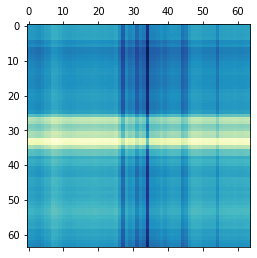

In [128]:
plt.matshow(total_score_inp[0], cmap=plt.cm.YlGnBu)

In [129]:
total_encoding_inp.size()

torch.Size([1129, 64, 512])

In [130]:
from sklearn.manifold import TSNE
tsne2d = TSNE(n_components=2, init='warn', random_state=2022)
inp_encoding_2d = tsne2d.fit_transform(total_encoding_inp.view(1129, -1))

/home/shizhaoshu/.conda/envs/torch111/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/shizhaoshu/.conda/envs/torch111/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


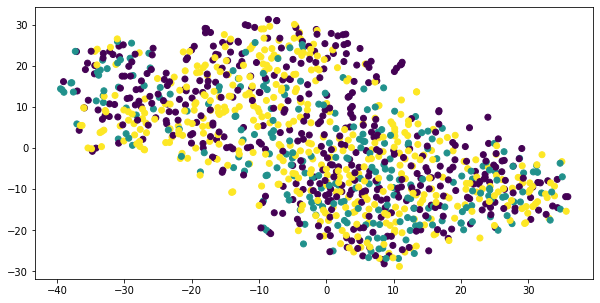

In [131]:
plt.figure(figsize=(10, 5))
plt.scatter(inp_encoding_2d[:, 0], inp_encoding_2d[:, 1], c=test_label, label="t-SNE")

/home/shizhaoshu/.conda/envs/torch111/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/shizhaoshu/.conda/envs/torch111/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


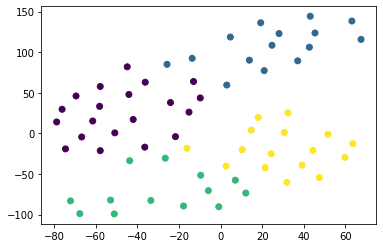

[2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 3 0]
[[-46.97098   25.656544]
 [ 24.99259  107.2151  ]
 [-27.873358 -72.49622 ]
 [ 29.829252 -19.608711]]
76201.65625
0.43867105


In [132]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt

tsne2d = TSNE(n_components=2, init='pca', random_state=2022)
inp_encoding_2d = tsne2d.fit_transform(total_encoding_inp[0].view(64, -1))

k_means = KMeans(n_clusters=4, random_state=2022)

k_means.fit(inp_encoding_2d)

y_predict = k_means.predict(inp_encoding_2d)
plt.scatter(inp_encoding_2d[:,0],inp_encoding_2d[:,1],c=y_predict)
plt.show()
print(k_means.predict((inp_encoding_2d)))
# print(metrics.calinski_harabaz_score(ch_encoding_2d,y_predict))
print(k_means.cluster_centers_)
print(k_means.inertia_)
print(metrics.silhouette_score(inp_encoding_2d,y_predict))
